Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Preparation

We load the MNIST dataset.

In [4]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We scale the images.

In [5]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [6]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(2048).batch(1024, True)

W0725 00:41:27.841485 140176499373888 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [8]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=kwargs['units'][0], activation=kwargs['activation'])
        self.hidden_layer_2 = tf.keras.layers.Dense(units=kwargs['units'][1], activation=kwargs['activation'])
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [9]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [10]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [11]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [12]:
model = NeuralNet(units=[512, 512], activation=tf.nn.sigmoid, num_classes=10)

We train our model for 300 epochs.

In [13]:
logistic_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 124.7784423828125, mean accuracy = 0.5070379972457886
epoch 100/300 : mean loss = 108.74200439453125, mean accuracy = 0.6303037405014038
epoch 150/300 : mean loss = 83.38124084472656, mean accuracy = 0.7079741358757019
epoch 200/300 : mean loss = 62.3278923034668, mean accuracy = 0.765473484992981
epoch 250/300 : mean loss = 49.61003112792969, mean accuracy = 0.8003939986228943
epoch 300/300 : mean loss = 41.713863372802734, mean accuracy = 0.8246060013771057


We produce predictions for the test data.

In [14]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [15]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [16]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8296999931335449


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [17]:
model = NeuralNet(units=[512, 512], activation=tf.nn.tanh, num_classes=10)

We train our model for 300 epochs.

In [18]:
tanh_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 24.04497718811035, mean accuracy = 0.8845972418785095
epoch 100/300 : mean loss = 19.832881927490234, mean accuracy = 0.9027478694915771
epoch 150/300 : mean loss = 18.122785568237305, mean accuracy = 0.9102909564971924
epoch 200/300 : mean loss = 17.044836044311523, mean accuracy = 0.9157125353813171
epoch 250/300 : mean loss = 16.227697372436523, mean accuracy = 0.921016275882721
epoch 300/300 : mean loss = 15.586588859558105, mean accuracy = 0.9237776398658752


We produce predictions for the test data.

In [19]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [20]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [21]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9258000254631042


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [22]:
model = NeuralNet(units=[512, 512], activation=tf.nn.relu, num_classes=10)

We train our model for 300 epochs.

In [23]:
relu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 24.928585052490234, mean accuracy = 0.882442057132721
epoch 100/300 : mean loss = 18.626220703125, mean accuracy = 0.9087755680084229
epoch 150/300 : mean loss = 16.071142196655273, mean accuracy = 0.9209152460098267
epoch 200/300 : mean loss = 14.371700286865234, mean accuracy = 0.9297885298728943
epoch 250/300 : mean loss = 13.061522483825684, mean accuracy = 0.9363887310028076
epoch 300/300 : mean loss = 11.98165512084961, mean accuracy = 0.9418103694915771


We produce predictions for the test data.

In [24]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [25]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [26]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9412000179290771


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [27]:
model = NeuralNet(units=[512, 512], activation=tf.nn.leaky_relu, num_classes=10)

We train our model for 300 epochs.

In [28]:
lrelu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 25.068567276000977, mean accuracy = 0.8803879022598267
epoch 100/300 : mean loss = 19.287147521972656, mean accuracy = 0.9044989347457886
epoch 150/300 : mean loss = 16.926044464111328, mean accuracy = 0.9168238043785095
epoch 200/300 : mean loss = 15.40997314453125, mean accuracy = 0.924686849117279
epoch 250/300 : mean loss = 14.219915390014648, mean accuracy = 0.9307987689971924
epoch 300/300 : mean loss = 13.258723258972168, mean accuracy = 0.9355636835098267


We produce predictions for the test data.

In [29]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [30]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [31]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9373999834060669


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [32]:
model = NeuralNet(units=[512, 512], activation=tf.nn.softplus, num_classes=10)

We train our model for 300 epochs.

In [33]:
softplus_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 32.23427200317383, mean accuracy = 0.8564285039901733
epoch 100/300 : mean loss = 23.22943878173828, mean accuracy = 0.8862641453742981
epoch 150/300 : mean loss = 20.63576316833496, mean accuracy = 0.8977471590042114
epoch 200/300 : mean loss = 19.257965087890625, mean accuracy = 0.9044315814971924
epoch 250/300 : mean loss = 18.342811584472656, mean accuracy = 0.9096847772598267
epoch 300/300 : mean loss = 17.718326568603516, mean accuracy = 0.912109375


We produce predictions for the test data.

In [34]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [35]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [36]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9139999747276306


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [37]:
model = NeuralNet(units=[512, 512], activation=tf.nn.elu, num_classes=10)

We train our model for 300 epochs.

In [38]:
elu_performance = train(model, loss_fn, dataset, epochs=300)

epoch 50/300 : mean loss = 23.9267578125, mean accuracy = 0.88427734375
epoch 100/300 : mean loss = 19.691787719726562, mean accuracy = 0.9035897254943848
epoch 150/300 : mean loss = 17.95671272277832, mean accuracy = 0.911250650882721
epoch 200/300 : mean loss = 16.896404266357422, mean accuracy = 0.9170258641242981
epoch 250/300 : mean loss = 16.09600257873535, mean accuracy = 0.92138671875
epoch 300/300 : mean loss = 15.433945655822754, mean accuracy = 0.9244847893714905


We produce predictions for the test data.

In [39]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [40]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [41]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9261999726295471


## Training Performance

We lay down the training performance of each model.

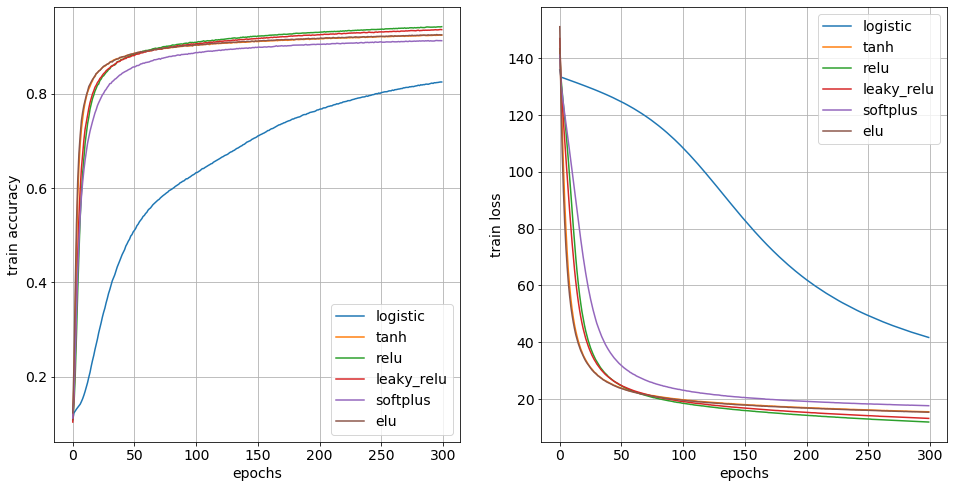

In [44]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.savefig('mnist_performance.png', dpi=300)
plt.show()